In [1]:
# %%capture cap
!pip install -q ipywidgets
!pip install -q autogluon scikit-learn==1.5.2 
!apt-get install -q -y graphviz graphviz-dev && pip install -q pydot
!pip install -q pygraphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.9/454.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.3/487.3 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.7/189.7 kB 7.8 MB/s eta 0:00:

In [2]:
import torch
import os
import pydot

import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from time import time, sleep
from itertools import combinations

from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

## -- Set Global Seed --
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

pd.set_option('display.max_columns', 500)
# plt.style.use("ggplot")
# sns.set_style("whitegrid")

## -- Ansi color codes --
COLOR = '\033[32m'
RESET = '\033[0m'

print("Packages import succesful!")

Packages import succesful!


In [3]:
### Load Data ###
PATH = "/kaggle/input/playground-series-s5e11/"
submit = pd.read_csv(PATH+"sample_submission.csv")

TARGET = "loan_paid_back"
train = pd.read_csv(PATH+"train.csv").drop(['id'], axis=1)
test = pd.read_csv(PATH+"test.csv").drop(['id'], axis=1)

NUMS = test.select_dtypes(include='number').columns.tolist()
CATS = test.select_dtypes(exclude='number').columns.tolist()
BASE = NUMS + CATS

ORIG_PATH = "/kaggle/input/loan-prediction-dataset-2025/"
orig = pd.read_csv(ORIG_PATH+"loan_dataset_20000.csv")[BASE+[TARGET]]

for (name, df) in dict(Train=train, Test=test, Original=orig).items():
    print(f"{name} shape: {df.shape}")

print(f"\nTotal Numerical: {len(NUMS)}")
print(f"Total Categorical: {len(CATS)}")
print(f"Total base features: {len(BASE)}")

Train shape: (593994, 12)
Test shape: (254569, 11)
Original shape: (20000, 12)

Total Numerical: 5
Total Categorical: 6
Total base features: 11


In [4]:
# ### Load Data ###
# PATH = "/kaggle/input/playground-series-s5e11/"
# submit = pd.read_csv(PATH+"sample_submission.csv")

# TARGET = "debt_to_income_ratio"
# train = pd.read_csv(PATH+"train.csv").drop(['id', "loan_paid_back"], axis=1)
# test = pd.read_csv(PATH+"test.csv").drop(['id', TARGET], axis=1)

# NUMS = test.select_dtypes(include='number').columns.tolist()
# CATS = test.select_dtypes(exclude='number').columns.tolist()
# BASE = NUMS + CATS

# ORIG_PATH = "/kaggle/input/loan-prediction-dataset-2025/"
# orig = pd.read_csv(ORIG_PATH+"loan_dataset_20000.csv")[BASE+[TARGET]]

# for (name, df) in dict(Train=train, Test=test, Original=orig).items():
#     print(f"{name} shape: {df.shape}")

# print(f"\nTotal Numerical: {len(NUMS)}")
# print(f"Total Categorical: {len(CATS)}")
# print(f"Total base features: {len(BASE)}")

In [5]:
## -- Define categories for OHE --
CAT_COLS = [c for c in BASE if train[c].dtype=='object' or train[c].nunique() <= 0.01*len(train)]
print(f"ℹ️ Features for TE: {len(CAT_COLS)} -> {CAT_COLS}")

ℹ️ Features for TE: 9 -> ['debt_to_income_ratio', 'credit_score', 'interest_rate', 'gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']


In [6]:
ROUND = []
for col in tqdm(['annual_income', 'loan_amount']):
    for r in [-3, -2, -1, 0]:
        n = f"{col}_r{r}"
        train[n] = train[col].round(r).astype(int)
        test[n] = test[col].round(r).astype(int)
        orig[n] = test[col].round(r).astype(int)
        ROUND.append(n)

print(f'{len(ROUND)} ROUND Features created.')
print(train[ROUND].nunique())

DIGITS = []
for col in tqdm(['debt_to_income_ratio']):
    for d in range(1, 4):
        n = f'{col}_d{d}'
        train[n] = ((train[col] * 10**d) % 10).fillna(-1).astype(int)
        test[n]  = ((test[col]  * 10**d) % 10).fillna(-1).astype(int)
        orig[n]  = ((orig[col]  * 10**d) % 10).fillna(-1).astype(int)

        ## -- Drop constant features --
        if train[n].nunique() < 2:
            train.drop([n], axis=1, inplace=True)
            test.drop([n],  axis=1, inplace=True)
            orig.drop([n],  axis=1, inplace=True)
        else:
            DIGITS.append(n)

for col in tqdm(['interest_rate']):
    for d in range(1, 3):
        n = f'{col}_d{d}'
        train[n] = ((train[col] * 10**d) % 10).fillna(-1).astype(int)
        test[n]  = ((test[col]  * 10**d) % 10).fillna(-1).astype(int)
        orig[n]  = ((orig[col]  * 10**d) % 10).fillna(-1).astype(int)

        ## -- Drop constant features --
        if train[n].nunique() < 2:
            train.drop([n], axis=1, inplace=True)
            test.drop([n],  axis=1, inplace=True)
            orig.drop([n],  axis=1, inplace=True)
        else:
            DIGITS.append(n)

print(f'{len(DIGITS)} Features DIGITS extracted.')
print(train[DIGITS].nunique())

INTER = []
for col1, col2 in tqdm(list(combinations(CAT_COLS+DIGITS, 2)), desc="Pairwise"):
    new_col = f"{col1}-|-{col2}"
    train[new_col] = train[col1].astype(str) + '_' + train[col2].astype(str)
    test[new_col] = test[col1].astype(str) + '_' + test[col2].astype(str)
    orig[new_col] = orig[col1].astype(str) + '_' + orig[col2].astype(str)
    INTER.append(new_col)

print(f"Ineraction Features: {len(INTER)}")

  0%|          | 0/2 [00:00<?, ?it/s]

8 ROUND Features created.
annual_income_r-3      270
annual_income_r-2     1721
annual_income_r-1     9706
annual_income_r0     35523
loan_amount_r-3         49
loan_amount_r-2        426
loan_amount_r-1       3558
loan_amount_r0       21644
dtype: int64


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

5 Features DIGITS extracted.
debt_to_income_ratio_d1     7
debt_to_income_ratio_d2    10
debt_to_income_ratio_d3    10
interest_rate_d1           10
interest_rate_d2           10
dtype: int64


Pairwise:   0%|          | 0/91 [00:00<?, ?it/s]

Ineraction Features: 91


In [7]:
ORIG = []

if 'y' in orig.columns:
    BASE.append('y')

for col in tqdm(BASE): # +ROUND
    # MEAN
    mean_map = orig.groupby(col)[TARGET].mean()
    mean_col = f"OTE_{col}_mean"
    mean_map.name = mean_col
    
    train = train.merge(mean_map, on=col, how='left')
    test = test.merge(mean_map, on=col, how='left')
    ORIG.append(mean_col)

    # COUNT
    count_col = f"OTE_{col}_count"
    count_map = orig.groupby(col).size().reset_index(name=count_col)
    
    train = train.merge(count_map, on=col, how='left')
    test = test.merge(count_map, on=col, how='left')
    ORIG.append(count_col)

print(len(ORIG), 'Orig Features Created!!')

  0%|          | 0/11 [00:00<?, ?it/s]

22 Orig Features Created!!


In [8]:
combined = pd.concat([train, test, orig], ignore_index=True)

## -- Factorize on=bjects --
for c in tqdm([i for i in CATS if train[i].dtype == 'object']):
    combined[c] = combined[c].factorize()[0]
    
## -- Categorize data --
for cat in CAT_COLS+DIGITS+INTER:
    combined[cat] = combined[cat].astype("category")

train = combined[:len(train)]
test  = combined[len(train):len(train)+len(test)]
orig  = combined[-len(orig):]

orig.shape, train.shape, test.shape

  0%|          | 0/6 [00:00<?, ?it/s]

((20000, 138), (593994, 138), (254569, 138))

In [9]:
display(train.head())
# train.info()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back,annual_income_r-3,annual_income_r-2,annual_income_r-1,annual_income_r0,loan_amount_r-3,loan_amount_r-2,loan_amount_r-1,loan_amount_r0,debt_to_income_ratio_d1,debt_to_income_ratio_d2,debt_to_income_ratio_d3,interest_rate_d1,interest_rate_d2,debt_to_income_ratio-|-credit_score,debt_to_income_ratio-|-interest_rate,debt_to_income_ratio-|-gender,debt_to_income_ratio-|-marital_status,debt_to_income_ratio-|-education_level,debt_to_income_ratio-|-employment_status,debt_to_income_ratio-|-loan_purpose,debt_to_income_ratio-|-grade_subgrade,debt_to_income_ratio-|-debt_to_income_ratio_d1,debt_to_income_ratio-|-debt_to_income_ratio_d2,debt_to_income_ratio-|-debt_to_income_ratio_d3,debt_to_income_ratio-|-interest_rate_d1,debt_to_income_ratio-|-interest_rate_d2,credit_score-|-interest_rate,credit_score-|-gender,credit_score-|-marital_status,credit_score-|-education_level,credit_score-|-employment_status,credit_score-|-loan_purpose,credit_score-|-grade_subgrade,credit_score-|-debt_to_income_ratio_d1,credit_score-|-debt_to_income_ratio_d2,credit_score-|-debt_to_income_ratio_d3,credit_score-|-interest_rate_d1,credit_score-|-interest_rate_d2,interest_rate-|-gender,interest_rate-|-marital_status,interest_rate-|-education_level,interest_rate-|-employment_status,interest_rate-|-loan_purpose,interest_rate-|-grade_subgrade,interest_rate-|-debt_to_income_ratio_d1,interest_rate-|-debt_to_income_ratio_d2,interest_rate-|-debt_to_income_ratio_d3,interest_rate-|-interest_rate_d1,interest_rate-|-interest_rate_d2,gender-|-marital_status,gender-|-education_level,gender-|-employment_status,gender-|-loan_purpose,gender-|-grade_subgrade,gender-|-debt_to_income_ratio_d1,gender-|-debt_to_income_ratio_d2,gender-|-debt_to_income_ratio_d3,gender-|-interest_rate_d1,gender-|-interest_rate_d2,marital_status-|-education_level,marital_status-|-employment_status,marital_status-|-loan_purpose,marital_status-|-grade_subgrade,marital_status-|-debt_to_income_ratio_d1,marital_status-|-debt_to_income_ratio_d2,marital_status-|-debt_to_income_ratio_d3,marital_status-|-interest_rate_d1,marital_status-|-interest_rate_d2,education_level-|-employment_status,education_level-|-loan_purpose,education_level-|-grade_subgrade,education_level-|-debt_to_income_ratio_d1,education_level-|-debt_to_income_ratio_d2,education_level-|-debt_to_income_ratio_d3,education_level-|-interest_rate_d1,education_level-|-interest_rate_d2,employment_status-|-loan_purpose,employment_status-|-grade_subgrade,employment_status-|-debt_to_income_ratio_d1,employment_status-|-debt_to_income_ratio_d2,employment_status-|-debt_to_income_ratio_d3,employment_status-|-interest_rate_d1,employment_status-|-interest_rate_d2,loan_purpose-|-grade_subgrade,loan_purpose-|-debt_to_income_ratio_d1,loan_purpose-|-debt_to_income_ratio_d2,loan_purpose-|-debt_to_income_ratio_d3,loan_purpose-|-interest_rate_d1,loan_purpose-|-interest_rate_d2,grade_subgrade-|-debt_to_income_ratio_d1,grade_subgrade-|-debt_to_income_ratio_d2,grade_subgrade-|-debt_to_income_ratio_d3,grade_subgrade-|-interest_rate_d1,grade_subgrade-|-interest_rate_d2,debt_to_income_ratio_d1-|-debt_to_income_ratio_d2,debt_to_income_ratio_d1-|-debt_to_income_ratio_d3,debt_to_income_ratio_d1-|-interest_rate_d1,debt_to_income_ratio_d1-|-interest_rate_d2,debt_to_income_ratio_d2-|-debt_to_income_ratio_d3,debt_to_income_ratio_d2-|-interest_rate_d1,debt_to_income_ratio_d2-|-interest_rate_d2,debt_to_income_ratio_d3-|-interest_rate_d1,debt_to_income_ratio_d3-|-interest_rate_d2,interest_rate_d1-|-interest_rate_d2,OTE_annual_income_mean,OTE_annual_income_count,OTE_debt_to_income_ratio_mean,OTE_debt_to_income_ratio_count,OTE_credit_score_mean,OTE_credit_score_count,OTE_loan_amount_mean,OTE_loan_amount_count,OTE_interest_rate_mean,OTE_interest_rate_count,OTE_gender_mean,OTE_gender_count,OTE_marital_status_mean,OTE_marita

In [10]:
display(test.head())
# test.info()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back,annual_income_r-3,annual_income_r-2,annual_income_r-1,annual_income_r0,loan_amount_r-3,loan_amount_r-2,loan_amount_r-1,loan_amount_r0,debt_to_income_ratio_d1,debt_to_income_ratio_d2,debt_to_income_ratio_d3,interest_rate_d1,interest_rate_d2,debt_to_income_ratio-|-credit_score,debt_to_income_ratio-|-interest_rate,debt_to_income_ratio-|-gender,debt_to_income_ratio-|-marital_status,debt_to_income_ratio-|-education_level,debt_to_income_ratio-|-employment_status,debt_to_income_ratio-|-loan_purpose,debt_to_income_ratio-|-grade_subgrade,debt_to_income_ratio-|-debt_to_income_ratio_d1,debt_to_income_ratio-|-debt_to_income_ratio_d2,debt_to_income_ratio-|-debt_to_income_ratio_d3,debt_to_income_ratio-|-interest_rate_d1,debt_to_income_ratio-|-interest_rate_d2,credit_score-|-interest_rate,credit_score-|-gender,credit_score-|-marital_status,credit_score-|-education_level,credit_score-|-employment_status,credit_score-|-loan_purpose,credit_score-|-grade_subgrade,credit_score-|-debt_to_income_ratio_d1,credit_score-|-debt_to_income_ratio_d2,credit_score-|-debt_to_income_ratio_d3,credit_score-|-interest_rate_d1,credit_score-|-interest_rate_d2,interest_rate-|-gender,interest_rate-|-marital_status,interest_rate-|-education_level,interest_rate-|-employment_status,interest_rate-|-loan_purpose,interest_rate-|-grade_subgrade,interest_rate-|-debt_to_income_ratio_d1,interest_rate-|-debt_to_income_ratio_d2,interest_rate-|-debt_to_income_ratio_d3,interest_rate-|-interest_rate_d1,interest_rate-|-interest_rate_d2,gender-|-marital_status,gender-|-education_level,gender-|-employment_status,gender-|-loan_purpose,gender-|-grade_subgrade,gender-|-debt_to_income_ratio_d1,gender-|-debt_to_income_ratio_d2,gender-|-debt_to_income_ratio_d3,gender-|-interest_rate_d1,gender-|-interest_rate_d2,marital_status-|-education_level,marital_status-|-employment_status,marital_status-|-loan_purpose,marital_status-|-grade_subgrade,marital_status-|-debt_to_income_ratio_d1,marital_status-|-debt_to_income_ratio_d2,marital_status-|-debt_to_income_ratio_d3,marital_status-|-interest_rate_d1,marital_status-|-interest_rate_d2,education_level-|-employment_status,education_level-|-loan_purpose,education_level-|-grade_subgrade,education_level-|-debt_to_income_ratio_d1,education_level-|-debt_to_income_ratio_d2,education_level-|-debt_to_income_ratio_d3,education_level-|-interest_rate_d1,education_level-|-interest_rate_d2,employment_status-|-loan_purpose,employment_status-|-grade_subgrade,employment_status-|-debt_to_income_ratio_d1,employment_status-|-debt_to_income_ratio_d2,employment_status-|-debt_to_income_ratio_d3,employment_status-|-interest_rate_d1,employment_status-|-interest_rate_d2,loan_purpose-|-grade_subgrade,loan_purpose-|-debt_to_income_ratio_d1,loan_purpose-|-debt_to_income_ratio_d2,loan_purpose-|-debt_to_income_ratio_d3,loan_purpose-|-interest_rate_d1,loan_purpose-|-interest_rate_d2,grade_subgrade-|-debt_to_income_ratio_d1,grade_subgrade-|-debt_to_income_ratio_d2,grade_subgrade-|-debt_to_income_ratio_d3,grade_subgrade-|-interest_rate_d1,grade_subgrade-|-interest_rate_d2,debt_to_income_ratio_d1-|-debt_to_income_ratio_d2,debt_to_income_ratio_d1-|-debt_to_income_ratio_d3,debt_to_income_ratio_d1-|-interest_rate_d1,debt_to_income_ratio_d1-|-interest_rate_d2,debt_to_income_ratio_d2-|-debt_to_income_ratio_d3,debt_to_income_ratio_d2-|-interest_rate_d1,debt_to_income_ratio_d2-|-interest_rate_d2,debt_to_income_ratio_d3-|-interest_rate_d1,debt_to_income_ratio_d3-|-interest_rate_d2,interest_rate_d1-|-interest_rate_d2,OTE_annual_income_mean,OTE_annual_income_count,OTE_debt_to_income_ratio_mean,OTE_debt_to_income_ratio_count,OTE_credit_score_mean,OTE_credit_score_count,OTE_loan_amount_mean,OTE_loan_amount_count,OTE_interest_rate_mean,OTE_interest_rate_count,OTE_gender_mean,OTE_gender_count,OTE_marital_status_mean,OTE_marita

In [11]:
# !rm -r /kaggle/working/AG_loan_models

In [12]:
from autogluon.tabular import TabularPredictor

In [13]:
## -- RUN 1: Use train data -- 
MODELS_PATH = "./AG_loan_models/"

predictor = TabularPredictor(
                label = TARGET,
         problem_type = "binary",
          eval_metric = "roc_auc",
                 path = MODELS_PATH,
    ).fit(
                   train_data = train,
                      presets = "best",
                num_bag_folds = 6,
             # dynamic_stacking = False,
             # num_stack_levels = 1,
                   time_limit = 3600*10.5,
                   # auto_stack = False,
                 # num_bag_sets = 2,
                  # ag_args_fit = {'num_cpus': os.cpu_count()},
) 

Preset alias specified: 'best' maps to 'best_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Sep 27 10:16:09 UTC 2025
CPU Count:          4
Memory Avail:       26.57 GB / 31.35 GB (84.7%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=6, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon w

In [14]:
## -- Get Summary -- 
print(f"-> Total models : {len(predictor.model_names())}")
print(f"-> Best model   : {predictor.model_best}") 

## -- Observe RUN 1 RESULTS -- 
leaderboard = predictor.leaderboard(silent=True)
leaderboard.style.background_gradient(subset=["score_val"], cmap="Spectral")

-> Total models : 19
-> Best model   : WeightedEnsemble_L3


,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.925121,roc_auc,561.181275,26975.901097,0.154539,66.206242,3,True,19
1,WeightedEnsemble_L2,0.925000,roc_auc,101.801319,14311.498941,0.151371,35.290769,2,True,10
2,CatBoost_BAG_L2,0.924794,roc_auc,404.154290,24134.779217,13.042367,5298.318259,2,True,15
3,CatBoost_BAG_L1,0.924662,roc_auc,24.801709,13222.020385,24.801709,13222.020385,1,True,5
4,XGBoost_BAG_L2,0.924173,roc_auc,429.002688,20000.725966,37.890765,1164.265008,2,True,18
5,LightGBMXT_BAG_L1,0.923528,roc_auc,16.474941,279.678221,16.474941,279.678221,1,True,1
6,RandomForestGini_BAG_L2,0.923328,roc_auc,447.406995,19509.593162,56.295071,673.132204,2,True,13
7,LightGBMXT_BAG_L2,0.923113,roc_auc,402.110506,19073.788724,10.998582,237.327767,2,True,11
8,ExtraTreesGini_BAG_L2,0.922986,roc_auc,445.280871,19017.019452,54.168948,180.558495,2,True,16
9,ExtraTreesEntr_BAG_L2,0.922823,roc_auc,450.262472,19064.982194,59.150548,228.521237,2,True,17


In [15]:
## -- RUN 2: Use original data as extra learning input --
# predictor.fit_pseudolabel(
#                 orig,
#                 use_ensemble = True,
#                 fit_ensemble = True,
#                 time_limit   = 3600*5,
#                 ag_args_fit  = {'num_cpus': os.cpu_count() - 1},
# )

In [16]:
## -- Get Summary -- 
# print(f"""
#     # {'█'*5}| Total models : {len(predictor.model_names())}
#     # {'█'*5}| Best model   : {predictor.model_best}
#         """)

# # -- Observe RUN 2 RESULTS --
# leaderboard = predictor.leaderboard(silent=True)
# display(leaderboard.style.background_gradient(subset=["score_val"], cmap="Spectral"))

In [17]:
## -- Create folder directory to save predictions --
SAVE_PATH = '/kaggle/working/AG_loan_predictions/'
!mkdir {SAVE_PATH}

In [18]:
%%time
## -- Generate predictions for all models --
ag_multi_test_proba = predictor.predict_proba_multi(test, as_multiclass=False)

## -- Save TEST predictions of all models --
final_test_data = {}
DESC = "Exporting TEST predictions"

for k, v in tqdm(ag_multi_test_proba.items(), desc=DESC):
    k_renamed = k.replace('_', '')
    final_test_data[k_renamed] = v

file_name = f"{SAVE_PATH}pred_ag_loan.parquet"

final_test_df = pd.DataFrame(final_test_data)
final_test_df.to_parquet(file_name, index=False)
final_test_df.head()

Exporting TEST predictions:   0%|          | 0/19 [00:00<?, ?it/s]

CPU times: user 13min 54s, sys: 21.9 s, total: 14min 16s
Wall time: 7min 27s


,LightGBMXTBAGL1,LightGBMBAGL1,RandomForestGiniBAGL1,RandomForestEntrBAGL1,CatBoostBAGL1,ExtraTreesGiniBAGL1,ExtraTreesEntrBAGL1,NeuralNetFastAIBAGL1,XGBoostBAGL1,WeightedEnsembleL2,LightGBMXTBAGL2,LightGBMBAGL2,RandomForestGiniBAGL2,RandomForestEntrBAGL2,CatBoostBAGL2,ExtraTreesGiniBAGL2,ExtraTreesEntrBAGL2,XGBoostBAGL2,WeightedEnsembleL3
593994,0.934567,0.929902,0.929629,0.941851,0.951119,0.928347,0.924012,0.960227,0.798994,0.945728,0.937827,0.946508,0.942935,0.929132,0.943159,0.935775,0.938244,0.785612,0.873930
593995,0.977279,0.973574,0.986537,0.981207,0.974060,0.981250,0.986111,0.978393,0.807203,0.975490,0.980662,0.980928,0.982511,0.986442,0.977590,0.982202,0.980676,0.788154,0.894271
593996,0.528990,0.506522,0.387466,0.394781,0.461111,0.400309,0.428983,0.391730,0.677981,0.475767,0.489151,0.462910,0.409876,0.475309,0.452574,0.418649,0.428808,0.734404,0.584852
593997,0.868006,0.831459,0.931333,0.916469,0.927086,0.937508,0.917780,0.886504,0.804772,0.909448,0.850714,0.821636,0.923451,0.903409,0.903773,0.902750,0.896455,0.782778,0.854027
593998,0.956619,0.953133,0.930019,0.947308,0.955600,0.958170,0.966869,0.978321,0.801122,0.955299,0.949418,0.957219,0.952241,0.963287,0.961095,0.959291,0.945388,0.786087,0.882236


In [19]:
%%time
## -- Get OOF predictions of all models --
ag_multi_oof_preds = {}
DESC1 = "Processing OOF probabilities"

for model in tqdm(predictor.model_names(), desc=DESC1):
    ag_multi_oof_preds[model] = predictor.predict_proba_oof(
                                             model = model,
                                        train_data = train,
                                     as_multiclass = False,
                                )

final_oof_data = {}
DESC2 = "Exporting OOF predictions"

for k, v in tqdm(ag_multi_oof_preds.items(), desc=DESC2):
    k_renamed = k.replace('_', '')
    final_oof_data[k_renamed] = v
    
file_name = f"{SAVE_PATH}oof_ag_loan.parquet"

final_oof_df = pd.DataFrame(final_oof_data)
final_oof_df.to_parquet(file_name, index=False)
final_oof_df.head()

Processing OOF probabilities:   0%|          | 0/19 [00:00<?, ?it/s]

Exporting OOF predictions:   0%|          | 0/19 [00:00<?, ?it/s]

CPU times: user 1.29 s, sys: 1.04 s, total: 2.33 s
Wall time: 3.1 s


,LightGBMXTBAGL1,LightGBMBAGL1,RandomForestGiniBAGL1,RandomForestEntrBAGL1,CatBoostBAGL1,ExtraTreesGiniBAGL1,ExtraTreesEntrBAGL1,NeuralNetFastAIBAGL1,XGBoostBAGL1,WeightedEnsembleL2,LightGBMXTBAGL2,LightGBMBAGL2,RandomForestGiniBAGL2,RandomForestEntrBAGL2,CatBoostBAGL2,ExtraTreesGiniBAGL2,ExtraTreesEntrBAGL2,XGBoostBAGL2,WeightedEnsembleL3
0,0.977266,0.975907,0.987528,0.982170,0.976507,0.981302,0.988086,0.992128,0.807122,0.977129,0.981709,0.983773,0.983522,0.976365,0.978529,0.983362,0.983589,0.788218,0.894233
1,0.476054,0.392821,0.695900,0.648700,0.585966,0.773183,0.638334,0.538230,0.739787,0.559044,0.531278,0.548509,0.596969,0.546293,0.577885,0.638866,0.574758,0.742294,0.642254
2,0.944105,0.883123,0.944251,0.958503,0.952775,0.952257,0.946497,0.969961,0.802365,0.950707,0.933198,0.886260,0.954064,0.916822,0.950129,0.947630,0.948099,0.785436,0.875310
3,0.820977,0.839698,0.901655,0.893964,0.880884,0.877793,0.849729,0.849463,0.791197,0.864702,0.900285,0.891242,0.853566,0.871778,0.847563,0.899150,0.846605,0.779476,0.825652
4,0.977399,0.971222,0.961968,0.964246,0.966297,0.957874,0.971888,0.988384,0.798923,0.969323,0.980168,0.978349,0.975033,0.988213,0.973277,0.965335,0.969284,0.787075,0.891268


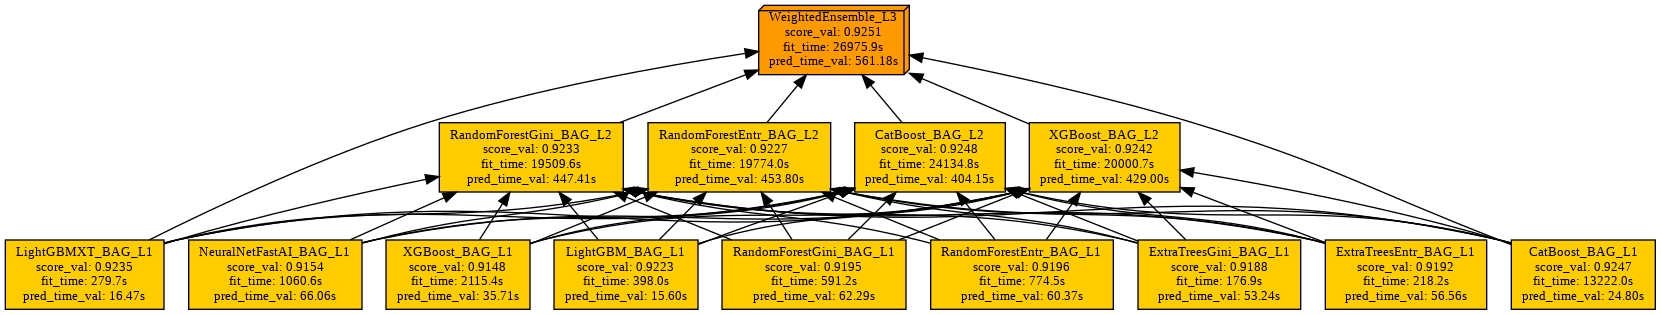

In [20]:
predictor.plot_ensemble_model(filename='ensemble_model.png')
display(Image(f'{MODELS_PATH}ensemble_model.png'))

In [21]:
# !zip -r /kaggle/working/AG_accident_models /kaggle/working/AG_accident_models.zip
# !zip -r {FOLDER}{NAME_EXT}.zip /kaggle/working/{FOLDER}{NAME_EXT}

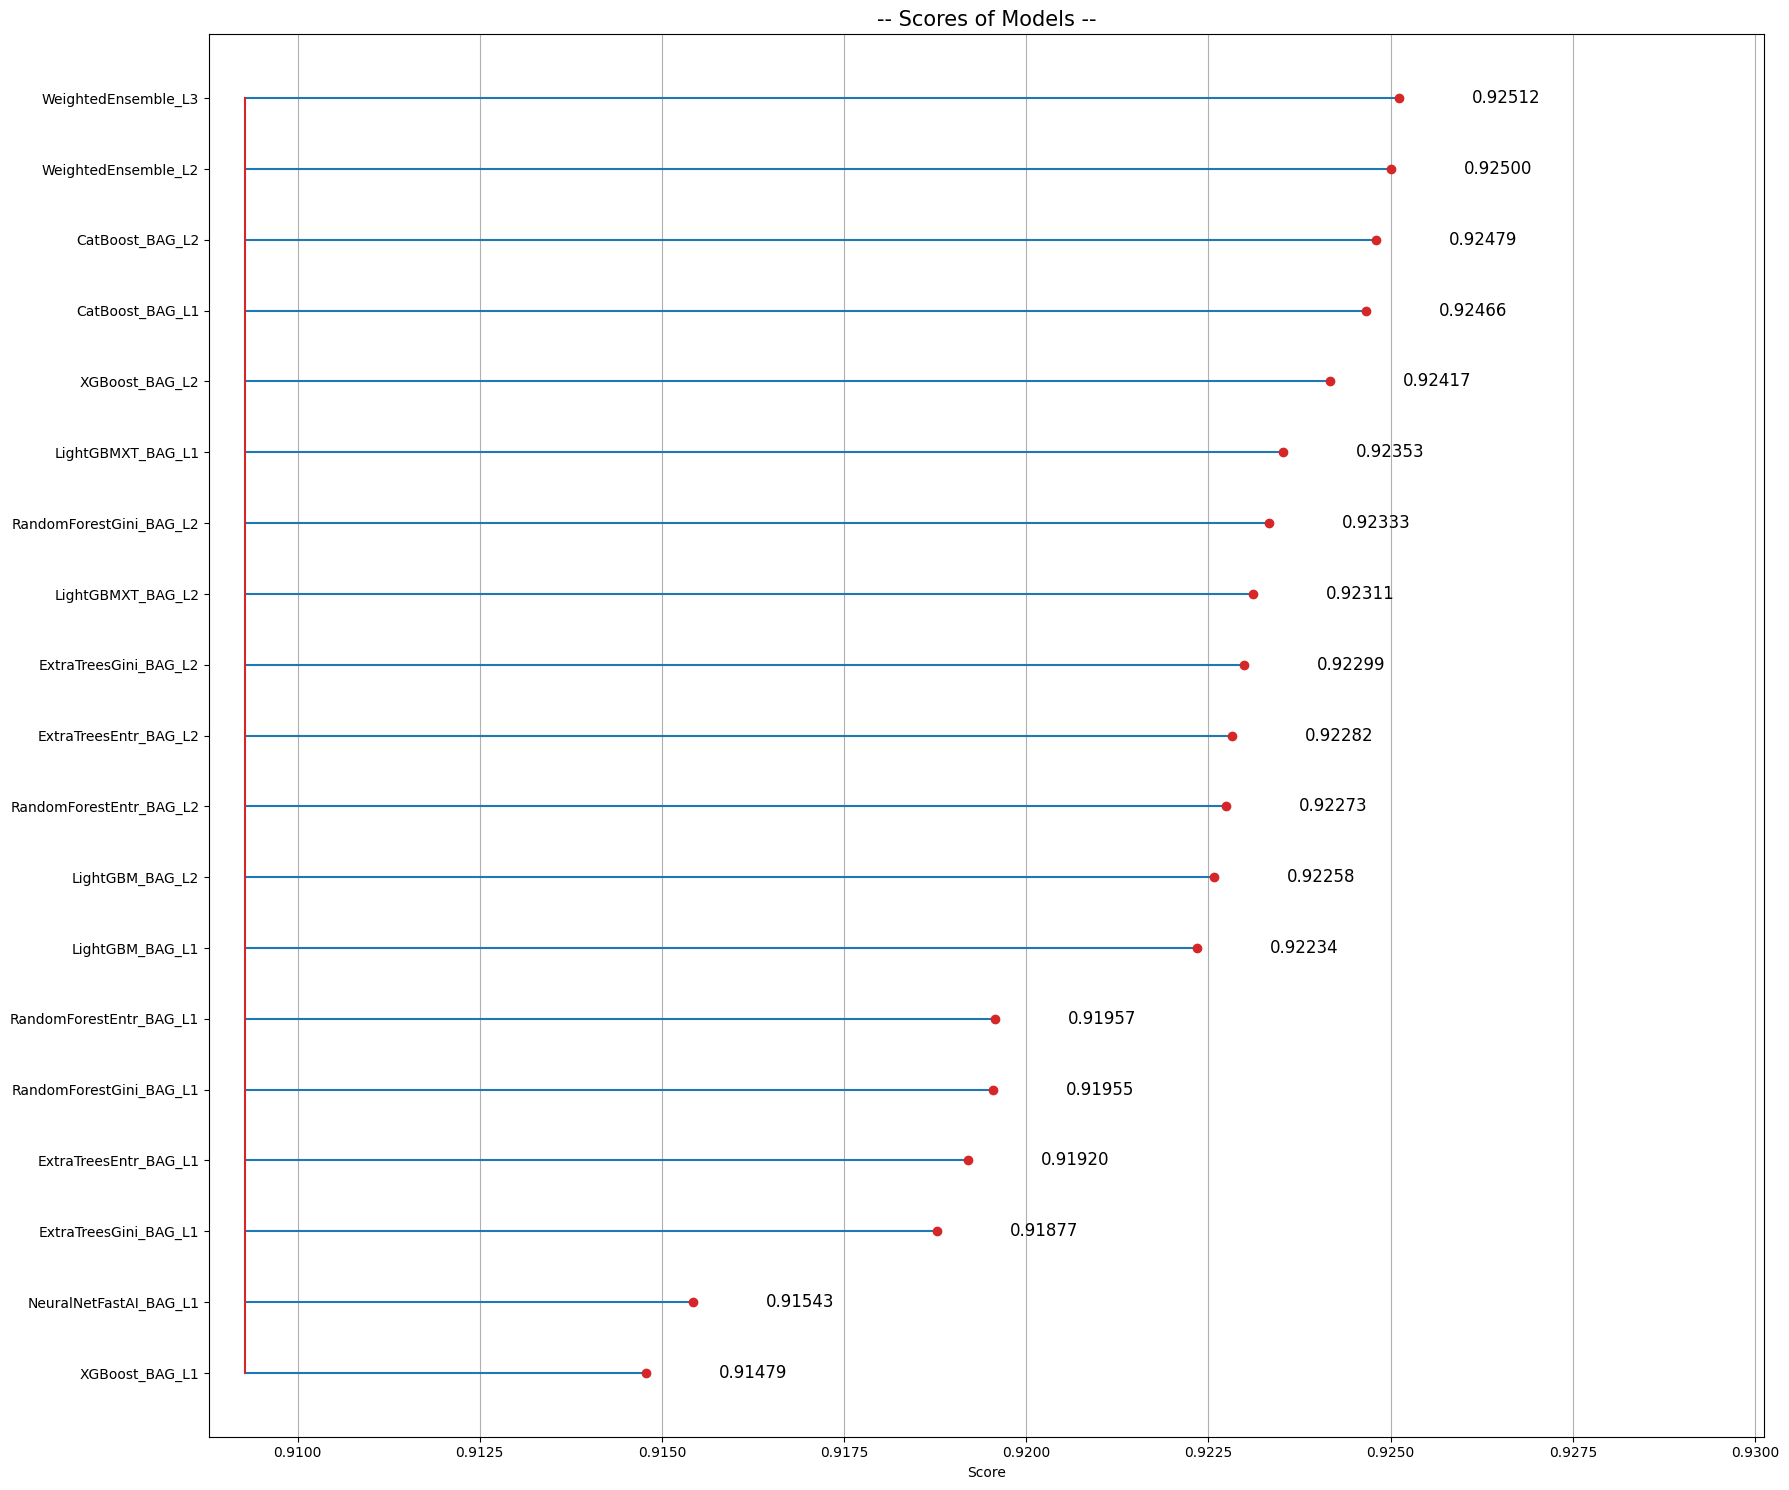

In [22]:
## -- Extract model scores --
result_ = dict(zip(leaderboard['model'], leaderboard['score_val']))
result_df = pd.DataFrame.from_dict(result_, orient='index').sort_values(0)

max_score = result_df.max().item()
min_score = result_df.min().item()

## -- PLOT MODELS & SCORES --
plt.figure(figsize=(18, 15))
plt.stem(
    result_df.index,
    result_df[0],
    orientation = 'horizontal',
    bottom = min_score - 0.0055,
    markerfmt = 'C3o'
)
plt.xlim(min_score - 0.006, max_score + 0.005)
plt.xlabel('Score')
plt.title('-- Scores of Models --', fontsize=15)

for i, value in enumerate(result_df[0]):
    plt.text(value+1e-3, i, f'{abs(value):.5f}', ha='left', va='center', fontdict=dict(size=12))

plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

In [23]:
# predictor.model_names()

In [24]:
# ## -- Permutation Feature Importances --
# feat_imp = predictor.feature_importance(
#                         data = X_test,
#                         # time_limit = 3600,
#                         # model = 'LightGBM_BAG_L1',
#                         # features = None,
#                         # feature_stage = 'transformed',
#                         # subsample_size = 5000,
#                         # num_shuffle_sets = 10,
#                         # include_confidence_band = True,
#                         confidence_level = 0.95,
#                         # silent = False
# ) 

# feat_imp.style.background_gradient(subset=["importance"], cmap="Spectral")

In [25]:
# plt.figure(figsize=(18, 35))
# sns.barplot(data=feat_imp, y=feat_imp.index, x=feat_imp.importance)
# plt.tick_params(axis='y', which='major', labelcolor='r')
# plt.title("Top Features by Permutation")
# plt.tight_layout()
# plt.show()

In [26]:
print(f"""
{'-'*48}
{'█'*5} | - AUTOGLUON NOTEBOOK COMPLETE! - | {'█'*5}
{'-'*48}
""")


------------------------------------------------
█████ | - AUTOGLUON NOTEBOOK COMPLETE! - | █████
------------------------------------------------



In [27]:
## -- OPTIONAL: Remove stored files --
!rm -r {MODELS_PATH}